In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("/content/Chat_BSA_Dataset.csv.csv")
df.dropna(subset=['TEXT', 'REACTION'], inplace=True)

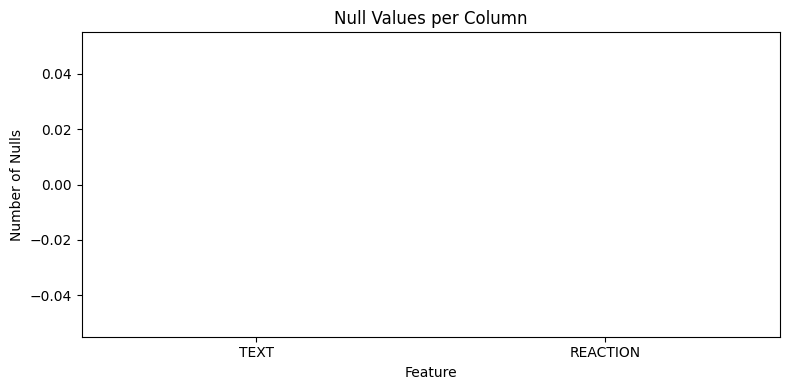

In [3]:
plt.figure(figsize=(8,4))
sns.barplot(x=df.columns, y=df.isnull().sum().values, hue=df.columns, legend=False)
plt.title("Null Values per Column")
plt.ylabel("Number of Nulls")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


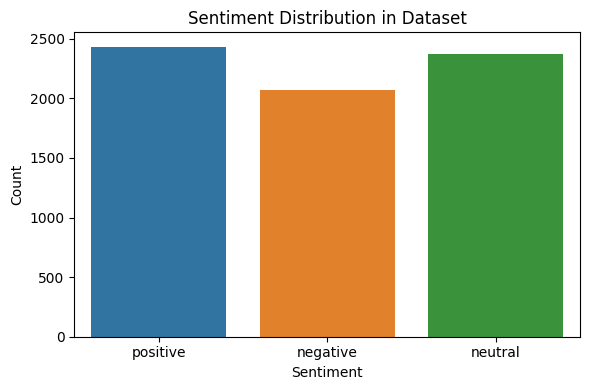

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='REACTION', hue='REACTION', legend=False)
plt.title("Sentiment Distribution in Dataset")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()

In [5]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['TEXT'] = df['TEXT'].apply(clean_text)


In [6]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['REACTION'])
# negative -> 0, neutral -> 1, positive -> 2

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['TEXT'],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [8]:
word_vect = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1,2),
    max_features=8000,
    stop_words='english',
    sublinear_tf=True
)

char_vect = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3,5),
    max_features=7000,
    sublinear_tf=True
)

vectorizer = FeatureUnion([
    ("word", word_vect),
    ("char", char_vect)
])

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [10]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_vec, y_train)

In [11]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_bal),
    y=y_train_bal
)

weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [12]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight=weight_dict,
    n_jobs=-1
)

lr.fit(X_train_bal, y_train_bal)

LogisticRegression(class_weight={0: np.float64(1.0), 1: np.float64(1.0),
                                 2: np.float64(1.0)},
                   max_iter=1000, n_jobs=-1)

In [13]:
y_pred = lr.predict(X_test_vec)

acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc * 100:.2f}%\n")

print(classification_report(y_test, y_pred, target_names=le.classes_))


✅ Accuracy: 77.45%

              precision    recall  f1-score   support

    negative       0.76      0.77      0.76       414
     neutral       0.74      0.75      0.74       475
    positive       0.82      0.80      0.81       486

    accuracy                           0.77      1375
   macro avg       0.77      0.77      0.77      1375
weighted avg       0.78      0.77      0.77      1375



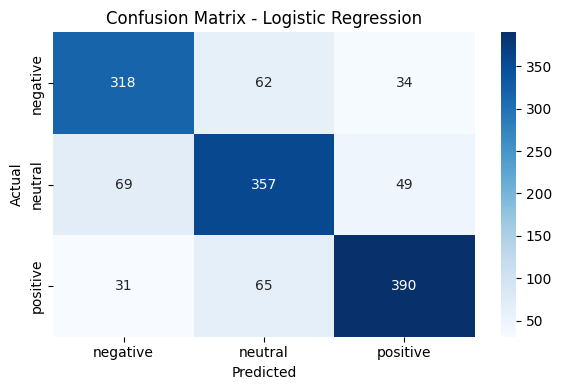

In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

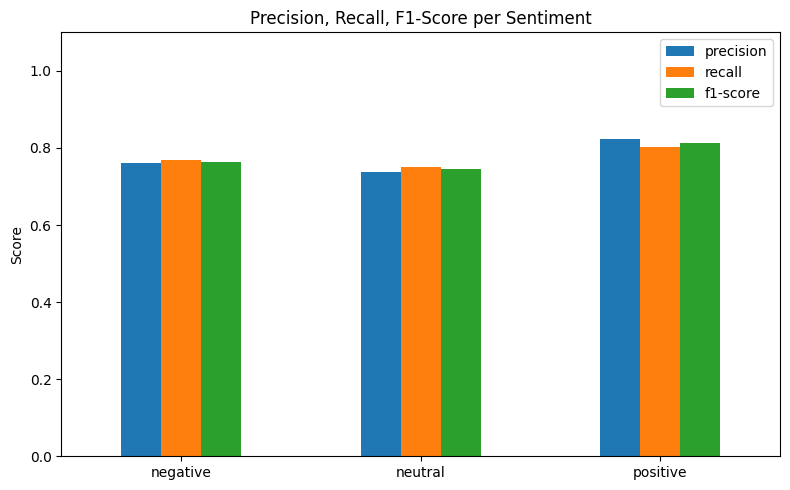

In [15]:
report = classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    output_dict=True
)

metrics_df = pd.DataFrame(report).T.iloc[:-3]
metrics_df[['precision','recall','f1-score']].plot(
    kind='bar',
    figsize=(8,5)
)

plt.title("Precision, Recall, F1-Score per Sentiment")
plt.ylabel("Score")
plt.ylim(0,1.1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
joblib.dump(lr, "logistic_sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")

print("✅ Model, vectorizer, and label encoder saved!")

✅ Model, vectorizer, and label encoder saved!


In [ ]:
loaded_model = joblib.load("logistic_sentiment_model.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")
loaded_label_encoder = joblib.load("label_encoder.pkl")

def predict_sentiment(text):
    cleaned = clean_text(text)
    vec = loaded_vectorizer.transform([cleaned])
    pred = loaded_model.predict(vec)
    return loaded_label_encoder.inverse_transform(pred)[0]


print("\nType exit or quit to exit:")
while True:
    text = input()
    if text.lower() in ["exit", "quit"]:
        break
    elif text.strip() == "":
        print("Please enter valid text")
    else:
        print(f"The sentiment of the text '{text}' is: {predict_sentiment(text)}")


Type exit or quit to exit:
